*Tim Boudreau <br>
tim.boudreau25@gmail.com* <br>
https://firstpitchswinging.wordpress.com/ <br>
https://github.com/timboudreau25/
***

# A Mile-High Impact on Baseball

*note: descriptions of some statistics were aided by Tangotiger (http://www.tangotiger.com/index.php)*

### The effects of Coors Field

As a resident of California, I've spent quite a bit of time watching games in NL West ballparks. Anytime the local team is in Colorado, I hear about the altitude and how it impacts the baseball. Using statistics and BaseballSavant data, I explored the impacts on pitch movement and batted balls from Coors Field. My hypothesis is that there is a significant and large influence on vertical pitch movement by the altitude, impacting pitch usage by pitchers.

In [1]:
%matplotlib inline

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import os
from tabulate import tabulate
import re

/Users/timb/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Source:

For this analysis, I used data from BaseballSavant (https://baseballsavant.mlb.com/about) and it's Statcast search tool. The data is from the entire 2017 MLB regular season.

## Data Acquisition:

### Database Formation:

Locally, I created the database separate from running my analysis, as the formation took a few minutes on my machine to run. Using a SQL database saved me quite a bit of time when I would run my analysis.

In [2]:
## create/connect to database

path = "Data/mlb_data.db"
conn = sqlite3.connect(path)
c = conn.cursor()

### SQL Query Into Database:

The variables of interest from my database were pitch characteristics and home team of the game each pitch was thrown in. The pitch characteristics I queried for are pitch type, release speed (in mph), release spin rate (in revolutions per minute), horizontal movement and vertical movement (both in inches). I used home team as a proxy for home field, as there has only been one series in which the home team wasn't in their home park: Houston during Hurricane Harvey.

In [3]:
## queries for our data

data = pd.read_sql("""SELECT home_team, pitch_type, release_speed, 
 	release_spin_rate, pfx_x, pfx_z, ID_Key.mlb_name, plate_x, plate_z, p_throws
    FROM MLB_2017
    JOIN ID_Key ON ID_Key.mlb_id = MLB_2017.pitcher
    WHERE pitch_type NOT IN ('FO', 'PO', 'EP', 'UN', 'AB')
 	;""", conn).dropna()


data_bats = pd.read_sql("""SELECT home_team, pitch_type, release_speed, 
 	release_spin_rate, pfx_x, pfx_z, ID_Key.mlb_name
    , bb_type, plate_x, plate_z, 
     launch_speed, launch_angle, hit_distance_sc
     FROM MLB_2017
    JOIN ID_Key ON ID_Key.mlb_id = MLB_2017.pitcher
 	;""", conn).dropna()

c.close()			# close connection to db

## Data Preparation:

Statcast measures pitch movement in feet from release, when prior measurements (and traditional describing of those measures) were in inches and at 40 feet from home plate. To correct this, Tangotiger recommended using a 1.67x normalization factor to compensate for the different measurement location (http://tangotiger.com/index.php/site/statcast-break-on-pitches).

For this analysis, I am presenting pitch movement in inches as if it were measured from 40 feet in front of home plate.

In [4]:
## correct the pitch movement for measurement location

data['pfx_x'] = data['pfx_x'] * 12 / 1.67
data['pfx_z'] = data['pfx_z'] * 12 / 1.67

Beyond correcting pitch movement, I also created dummy variables for each ballpark. This controlled for individual ballpark effects on pitch movement (which could be from varying altitudes, proximities to bodies of water, discrepencies in measurement tools, etc.). Then I filtered the dataset to only include pitchers who pitched in both Colorado and elsewhere. This allows for a stronger analysis, comparing those pitches in and out of Colorado. Lastly, I normalized horizontal pitch movement by pitcher handedness - previously, glove-side break for a righty was positive movement, while glove-side break to a lefty was negative. Now, any glove-side movement is negative, allowing arm-side run to be positive. This allows us to analyze changes in movement based purely on the pitch thrown, not pitch thrown plus hand of pitcher throwing.

In [5]:
## find list of pitchers who have thrown/batted in both colorado and elsewhere

home_team = "COL"

names = data['mlb_name'][data['home_team'] == home_team].unique()
names_bat = data_bats['mlb_name'][data_bats['home_team'] == home_team].unique()


## create dummies for each home park to control for parks

data = pd.concat([data, pd.get_dummies(data['home_team'], prefix = 'park')], axis = 1)
data = data.drop('park_SF', axis = 1) # remove one of the dummies to properly use them


## prepare batted ball data with a dummy for whether or not in Colorado

data_bats['col'] = (data_bats['home_team'] == "COL").astype(int)


## narrow our regression dataset down to pitchers who have thrown/hit in Colorado

data_sp = data[data['mlb_name'].isin(names)]
data_bats = data_bats[data_bats['mlb_name'].isin(names)]


## define pitch movements from query to regress against

pitch_movement = ['pfx_x', 'pfx_z']


## gather list of pitches thrown, to analyze individually

pitches = data_sp['pitch_type'].unique()


## normalize horizontal movement for handedness of pitcher - positive is arm-side movement

data_sp.loc[data_sp['p_throws'] == "R", ['pfx_x']] *= -1


## remove home team, as the dummy variables control for that

del data_sp['home_team']
del data_sp['mlb_name']
del data_sp['p_throws']

/Users/timb/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Pitch Analysis:

To fully capture altitude's effect on pitches, I looped through each pitch type and both dimensions of pitch movement to have multiple unique regressions. I stored the coefficient on Colorado and it's p-values, to see the effects and significance levels.



In [6]:
## regress pitch characteristics on other characteristics and the above-park

home_coef = pd.DataFrame([])		# stores values from regression loop


for pitch in pitches:     # look at each pitch type
    
    
    ## select data to regress - for each pitch type, and exclude variables not needed
    
    data_reg = data_sp[data_sp['pitch_type'] == pitch]
    data_reg = data_reg.drop(['pitch_type', 'plate_x', 'plate_z'], axis = 1)


    ## for both types of movement, regress park and pitch characteristics                          
                              
    for reg in pitch_movement:

        Y = data_reg[reg]
        X = data_reg.loc[:, data_reg.columns != reg]
                
        X = sm.add_constant(X)     # add constant

        results = sm.OLS(Y, X).fit()     # OLS regression
        
                    
        ## store values from regression                      
                              
        home_coef = home_coef.append(pd.DataFrame({ 'Colorado' : results.params['park_COL'],
            'Movement' : reg, 'P-Value' : round(results.pvalues[4], 4),
            'Pitch' : pitch}, index = [0]), ignore_index = True)


## reorder columns and print regression results in a nice table format

colorado_results = pd.DataFrame({"Pitch" : home_coef['Pitch'].unique(),
            "Coors V-Mov" : home_coef[home_coef['Movement'] == "pfx_x"]['Colorado'].values,
            "Coors H-Mov" : home_coef[home_coef['Movement'] == "pfx_z"]['Colorado'].values,
            "P-Value" : home_coef[home_coef['Movement'] == 'pfx_x']['P-Value'].values,
            "P-Value " : home_coef[home_coef['Movement'] == 'pfx_z']['P-Value'].values})

colorado_results = colorado_results[['Pitch', 'Coors V-Mov', 'P-Value',
                                     'Coors H-Mov', 'P-Value ']]



print tabulate(colorado_results.values, headers = colorado_results.columns, tablefmt = 'psql')

+---------+---------------+-----------+---------------+------------+
| Pitch   |   Coors V-Mov |   P-Value |   Coors H-Mov |   P-Value  |
|---------+---------------+-----------+---------------+------------|
| SL      |      0.398564 |    0      |    -1.4768    |          0 |
| FC      |      0.570576 |    0      |    -2.34079   |          0 |
| FF      |     -2.02122  |    0      |    -1.94771   |          0 |
| SI      |     -1.55     |    0.0002 |    -0.18329   |          0 |
| FT      |     -2.55026  |    0      |    -2.29692   |          0 |
| CH      |     -2.7788   |    0      |    -0.989404  |          0 |
| KC      |      0.551338 |    0.0407 |     0.135777  |          0 |
| CU      |      1.777    |    0      |    -0.0598116 |          0 |
| FS      |     -1.0592   |    0.0002 |    -1.0296    |          0 |
+---------+---------------+-----------+---------------+------------+


### Regression Results:


Sliders:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Almost a half-inchs less glove-side break
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Approximately 1 and a half inches more drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at 99% confidence level

Cutters:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- A little more than a half inch less cut
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Just under 2 and a half inches more drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at the 99% confidence level

Four-seam fastballs:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 2 inches less run
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 2 inches less rise
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at the 99% confidence level

Sinkers:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 1 and a half inches less run
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- About a fifth of an inch more drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at the 99% confidence level

Two-seam fastballs:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 2 and a half inches less run
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Almost 2 and a half inches less drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both statistically significant, at 99% confidence level.

Changeups:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 2.8 inches less run
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- About an inch more drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at the 99% confidence level

Knuckle curves:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- A half-inch decrease in gloveside movement
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- A slightly larger than one-tenth of an inch less drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Horizontal movement statistically significant at the 95% level, veritcal at 99% but again, not baseball significant.

Curveballs:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Almost 2 inches less movement to the glove side
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Essential no change in drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both statistically significant at the 99% level, though the vertical movement isn't 'baseball' significant (no realistic change in movement)

Split-finger fastballs:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- About an inch less run
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- About an inch more drop
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Both at the 99% confidence level

### Pitch Distribution

To see the impacts of these changes in pitch movements in Colorado, I chose to breakdown pitch types in Colorado versus elsewhere. 

/Users/timb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
/Users/timb/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


+---------+---------------+---------------+---------------------+
| Pitch   |   Coors V-Mov |   Coors H-Mov |   Change in Use (%) |
|---------+---------------+---------------+---------------------|
| FF      |         -2.02 |         -1.95 |               11.95 |
| FT      |         -2.55 |         -2.3  |               -6.44 |
| SI      |         -1.55 |         -0.18 |               -3.82 |
| CH      |         -2.78 |         -0.99 |               -2.01 |
| SL      |          0.4  |         -1.48 |                1.36 |
| KC      |          0.55 |          0.14 |               -1.28 |
| FC      |          0.57 |         -2.34 |                1.1  |
| FS      |         -1.06 |         -1.03 |               -1.05 |
| CU      |          1.78 |         -0.06 |                0.19 |
+---------+---------------+---------------+---------------------+


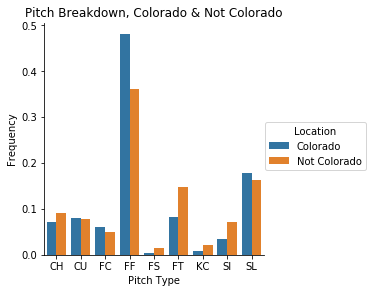

In [7]:
## aggregate pitch types by thrown in Coloardo or not Colorado
pitch_list = pd.crosstab(data_sp.pitch_type, data_sp.park_COL) 
pitch_list.columns = ["Not Colorado", "Colorado"]


## copy the list from above and remove park thrown - will replace with % thrown in Col/not

pitch_dist = pitch_list
pitch_dist = pitch_dist.drop(['Colorado', 'Not Colorado'], axis = 1)


## find the percentage of pitches that each pitch type is and format the data

pitch_dist['Colorado'] = pitch_list['Colorado'] / sum(pitch_list['Colorado'])
pitch_dist['Not Colorado'] = pitch_list['Not Colorado'] / sum(pitch_list['Not Colorado'])
pitch_dist['Pitch Type'] = pitch_dist.index


## create a new dataframe in the long format to plot from

pitch_dist_plot = pd.melt(pitch_dist, id_vars="Pitch Type", 
                          var_name = "Location", value_name = "Frequency")


## aggregate Coors impact on movement and changes in pitch use frequency into dataframes

    # find changes in frequency of pitches from Coors and elsewhere
dist_changes = (pitch_dist['Colorado'].sub(pitch_dist['Not Colorado']) * 100).to_frame()

    # grab movement data from regression dataframe
colorado_results_move = colorado_results.select(lambda x: not re.search('P-Value', x), axis=1)


## merge both dataframes and rename/reorder columns

movement_dist = pd.merge(colorado_results_move, dist_changes,
                         how = 'outer', left_on = "Pitch" , right_index = True)

movement_dist.rename(columns={0:'Change in Use (%)'}, inplace=True)

movement_dist = movement_dist[['Pitch', 'Coors V-Mov', 'Coors H-Mov', 'Change in Use (%)']].round(2)


## sort dataframe by total change in each pitch type (absolute value)

movement_dist = movement_dist.reindex(
    movement_dist['Change in Use (%)'].abs().sort_values(ascending= False).index)


## print summary of Coors effects in a nice format

print tabulate(movement_dist.values, headers = movement_dist.columns, tablefmt = 'psql')


## plot pitch distribution!

sns.factorplot(x = 'Pitch Type', y = 'Frequency', hue = 'Location', 
	data = pitch_dist_plot, kind = 'bar')

plt.title("Pitch Breakdown, Colorado & Not Colorado")

### Pitch Distribution Results

<br>
Remember, a positive horizontal movement change is less glove side or more arm side movement, and a positive vertical movement is more drop.
***
<br>
The most significant pitch usage changes:
<br>
<br>
<br>
Four-seam fastballs saw a massive increase in use - 11%. This could be attributed to their estimated 2 inch decrease in drop or, in common terms, an increase in rise.

Two-seam fastballs saw an approximately 6.5% decrease in usage. They saw an almost 2 and a half inch decrease in horizontal run and a 2 and a half inch decrease in vertical drop.

Sinkers saw an almost 4% decrease in use, for a similar reason as the two-seamer. Sinkers experience a 1 and a half inch decrease in drop.

Changeup usage was reduced by almost 2%. Again, likey because of an almost 3 inch reduction in drop.

Sliders saw a 1.3% increase in usage, despite a 1 and a half inch reduction in horizontal movement and a half-inch decrease in drop.

Knuckle curves experienced a 1.3% drop in usage. They broke gloveside slightly less and dropped a half-inch more.

Cutters saw a 1.1% increase in usage. They experienced almost 2 and a half inches more cut with about a half inch more drop.

Split-finger fastballs saw a 1% decrease in usage. Likely, this is due to a one inch decrease in drop and in armside run.

Curveballs saw almost no change in usage (a very slight increase, .2%). They saw almost no change in horizontal run (.06 inch increase in cut) but did see an almost 2 inch increase in vertical drop.

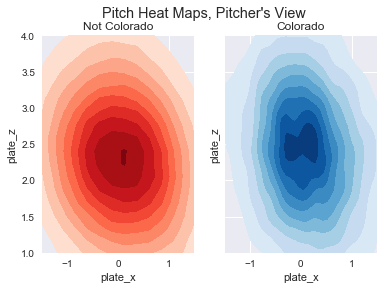

In [8]:
## prepare a plot with subplots

sns.set(style="darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
f.suptitle("Pitch Heat Maps, Pitcher's View")
plt.xlim(-1.5, 1.5)
plt.ylim(1, 4)


## plot pitch locations in heatmaps for in Colorado and elsewhere

ax1.set_title("Not Colorado")
sns.kdeplot(data['plate_x'][data['park_COL'] != 1], data['plate_z'][data['park_COL'] != 1], 
            cmap = "Reds", shade = True, shade_lowest = False, ax = ax1)

ax2.set_title("Colorado")
sns.kdeplot(data['plate_x'][data['park_COL'] == 1], data['plate_z'][data['park_COL'] == 1], 
            cmap = "Blues", shade = True, shade_lowest = False, ax = ax2)

These heat maps of pitch locations are from the catcher's view, with (0, 2.5 feet) as the center of the plate. They may take a minute or two to load.

Pitchers in Colorado seems to favor two locations, neither of which is where the rest of the league dominantl pitches. The first is over the left side of the plate, which is away from lefties and inside to righties. The second is up and in to lefties. My theory as to why these are the focal points of pitch locating in Colorad is that right field is where batted balls could cause the most damage, as the Rockies heightened the right-center field wall. Pitchers are trying to either have the ball hit to left field or weakly to right field. In another analysis, I may revist this idea and explore where in certain ballparks batted balls are most damaging. 

## Batting Analysis:



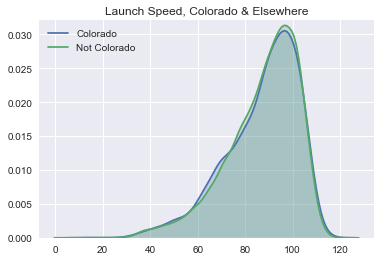

In [9]:
## plot frequency plots for exit velocity in Colorado and everywhere else

sns.kdeplot(data_bats['launch_speed'][data_bats['col'] == 1], shade = True, label = "Colorado")
sns.kdeplot(data_bats['launch_speed'][data_bats['col'] != 1], shade = True, label = "Not Colorado")
plt.legend()
plt.title("Launch Speed, Colorado & Elsewhere")
plt.show()

As seen above, the shape of exit velocity distributions are similar both in Colorado and out. In Colorado, however, There are fewer balls hit around 70-80 mph and more hit between about 85-95 mph. As exit velocity is measured off the bat, this would have to be influenced by changes in pitch characteristics - or batters swinging differently.

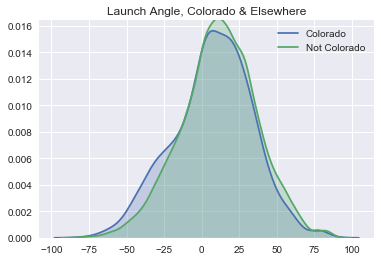

In [10]:
## plot frequency plots for launch angle in Colorado and everywhere else

sns.kdeplot(data_bats['launch_angle'][data_bats['col'] == 1], shade = True, label = "Colorado")
sns.kdeplot(data_bats['launch_angle'][data_bats['col'] != 1], shade = True, label = "Not Colorado")
plt.legend()
plt.title("Launch Angle, Colorado & Elsewhere")
plt.show()

The launch angle distributions for in Colorado and outside Colorado are similar, as before. However, batters in Colorado hit more ground balls (in the -70 to -20 degree launch angle zone) and fewer fly balls (in the 5 to 40 degree launch angle zone). This is likely due to changes in pitch selection or zones pitched to by pitchers, but could also be a failed attempt by batters to elevate the ball more at altitude.

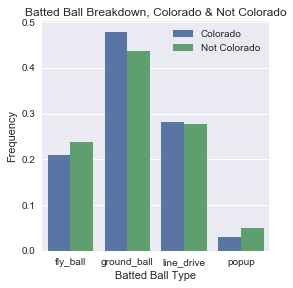

In [11]:
## remove all null string data in batted balls (earlier listed as 123456789)

data_bats = data_bats[data_bats['bb_type'] != ""]


## Gather batted ball data and format the data properly

batted_balls = pd.crosstab(data_bats.bb_type, data_bats.col)
batted_balls.columns = ['Not Colorado', 'Colorado']

batted_balls_dist = batted_balls
batted_balls_dist = batted_balls_dist.drop(['Colorado', 'Not Colorado'], axis = 1)


## find the percentage of batted balls that each batted ball type is and format the data

batted_balls_dist['Colorado'] = batted_balls['Colorado'] / sum(batted_balls['Colorado'])
batted_balls_dist['Not Colorado'] = batted_balls['Not Colorado'] / sum(batted_balls['Not Colorado'])
batted_balls_dist['Batted Ball Type'] = batted_balls_dist.index

batted_balls_plot = pd.melt(batted_balls_dist, id_vars="Batted Ball Type", var_name = "Location"
	, value_name = "Frequency")


## plot!

sns.factorplot(x = 'Batted Ball Type', y = 'Frequency', hue = 'Location', 
	data = batted_balls_plot, kind = 'bar', legend = False)

plt.title("Batted Ball Breakdown, Colorado & Not Colorado")
plt.legend(loc = 'upper right')

Whether a result of the changed pitch distribution, pitch location or batter approach, there is a noticable change in the batted ball distribution in Colorado versus elsewhere. There are fewer fly balls and pop ups and, to offset that, an increased amount of fly balls. There isn't much change in line drive rates, which is expected, as it is generally accepted that line drives, from a pitcher's perspective, appear as random occurances and aren't controllable.

## Problems & Issues

One problem I had was the result of what I assume to be incomplete modeling. I expected and still assume that altitude has a larger impact on pitches, specificaly breaking pitches, than what my model suggests. To fix this, I would need to search for different variables in this or other datasets, while considering different models as well, as the issue could be the model itself. 

Another problem I encountered was multicollinearity within my model. Many of the regressions ran had multicollinearity issues. Below is my calculation for the condition number of this model. A condition number of a function or model describes how much the dependent variable can change with a small change in the independent variables - a larger condition number implies an error in input variable measure will greatly increase the error in output variable. The condition number is extremely large, which heavily implies multicollinearity is an issue. It may be best to accept there is multicollinearity, likely through an instrumental variable I failed to account for. I will try to revisit this another day.

An issue I had with this project was, in my opinion, the lack of structure in my plan to attack my hypothesis. There is enough data to make one's head spin! I chose to browse what I deemed were interesting or important details, but felt I left many out while at the same time not having a flow between pieces.

In [12]:
## source for this code: http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

## 
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":            ## skip the constant from the model
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])    ## normalize values
norm_xtx = np.dot(norm_x.T,norm_x)

eigs = np.linalg.eigvals(norm_xtx)                   ## collect eigenvalues from normalized data
condition_number = np.sqrt(eigs.max() / eigs.min())  ## calculate condition number

print "\nCondition Number: ", (condition_number)


Condition Number:  (2390.6431097181426+0j)


## Conclusion

Altitude significantly affects pitches. This has been known by players, coaches and fans since Colorado received a Major League team. Batters hit the ball harder and higher (as well as lower) than elsewhere, likely to try to take advantage of the thinner atmosphere and further carry. Pitchers recognize these conditions and throw different pitches, in different locations, to prevent this. The distribution of batted balls in Colorado, compared to other stadiums, reflects this - there is a decrease in fly balls and increase in ground balls despite batters hitting the ball harder and likely trying to lift the ball. With strike-zone data, such as bat path and speed, I could explore that further.

I was able to somewhat verify my hypothesis - many pitch types have a significant impact on vertical movement by altitude. Surprisingly, though, my model suggested altitude doesn't impact the most drastic breaking pitches, curveballs. I'm skeptical of these results, and need to further explore this.

### Next Steps:

- Work on the variables/statistical style of my model to more accurately analyze the data.
- Gather more data to include in the model that could be missing and impacting my results.
- Search for data on bat angle and speed to statistically see if there is a change in approach by batters, or batters of certain types.